In [9]:
import os 
import sys
while os.path.split(os.getcwd())[1] != 'RecSysChallenge2023-Team':
    os.chdir('..')
sys.path.insert(1, os.getcwd())

import numpy as np 

In [10]:
path_save= "Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_models"
if not os.path.exists(path_save):
    os.makedirs(path_save)

In [11]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Evaluation.Evaluator import EvaluatorHoldout

import Daniele.Utils.MyDataManager as dm 
import Daniele.Utils.MatrixManipulation as mm
import Daniele.Utils.SaveSparceMatrix as ssm

URMv = dm.getURMviews()
URMo = dm.getURMopen()
ICMt=dm.getICMt()
ICMl=dm.getICMl()

name="train.csv"
dir = os.path.join(path_save,name)
if not os.path.exists(dir+".csv"):
    URMv_train, URMv_test = split_train_in_two_percentage_global_sample(URMv, train_percentage = 0.80)

    ssm.saveMatrix(dir,URMv_train)

    name="test.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,URMv_test)

    urm_def = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo,icml=ICMl,icmt=ICMt, normalize=True, add_aug=True,appendICM=True)
    name="urm_def.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,urm_def)

    urm_bin = mm.defaultExplicitURM(urmv=URMv_train,urmo=URMo, normalize=False, add_aug=True)
    urm_bin.data = np.ones(len(urm_bin.data))
    name="urm_bin.csv"
    dir = os.path.join(path_save,name)
    ssm.saveMatrix(dir,urm_bin)

else:
    URMv_train=ssm.readMatrix(dir)

    name="test.csv"
    dir = os.path.join(path_save,name)
    URMv_test=ssm.readMatrix(dir)

    name="urm_def.csv"
    dir = os.path.join(path_save,name)
    urm_def = ssm.readMatrix(dir)

    name="urm_bin.csv"
    dir = os.path.join(path_save,name)
    urm_bin = ssm.readMatrix(dir)



100%|██████████| 663370/663370 [00:00<00:00, 1670360.00it/s]


### SSLIIM

In [12]:
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
name="sslim01"
dir = os.path.join(path_save,name)

sslim_recommender = SLIM_BPR_Cython(URM_train=urm_def)
if not os.path.exists(dir+".zip"):
    sslim_recommender.fit(topK= 305, epochs=25,symmetric=True, sgd_mode = 'adam', lambda_i = 0.0008132913041259862, lambda_j=0.004889521240194745, learning_rate = 0.005381553515814384)
    sslim_recommender.save_model(path_save,name)
else:
    sslim_recommender.load_model(path_save,name)
   

SLIM_BPR_Recommender: URM Detected 2 ( 0.0%) users with no interactions.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.


/bin/sh: free: command not found


Processed 70335 (100.0%) in 3.63 sec. BPR loss is 8.31E-01. Sample per second: 19371
SLIM_BPR_Recommender: Epoch 1 of 25. Elapsed time 3.04 sec
Processed 70335 (100.0%) in 2.55 sec. BPR loss is 3.10E+00. Sample per second: 27560
SLIM_BPR_Recommender: Epoch 2 of 25. Elapsed time 4.95 sec
Processed 70335 (100.0%) in 0.95 sec. BPR loss is 5.52E+00. Sample per second: 74238
SLIM_BPR_Recommender: Epoch 3 of 25. Elapsed time 5.35 sec
Processed 70335 (100.0%) in 1.18 sec. BPR loss is 7.52E+00. Sample per second: 59478
SLIM_BPR_Recommender: Epoch 4 of 25. Elapsed time 5.58 sec
Processed 70335 (100.0%) in 0.41 sec. BPR loss is 9.39E+00. Sample per second: 170081
SLIM_BPR_Recommender: Epoch 5 of 25. Elapsed time 5.81 sec
Processed 70335 (100.0%) in 0.63 sec. BPR loss is 1.12E+01. Sample per second: 111469
SLIM_BPR_Recommender: Epoch 6 of 25. Elapsed time 6.03 sec
Processed 70335 (100.0%) in 0.83 sec. BPR loss is 1.35E+01. Sample per second: 84648
SLIM_BPR_Recommender: Epoch 7 of 25. Elapsed time

### KNN_CFCBF 

In [13]:
from Daniele.Recommenders.KNN_CFCBF.ItemKNN_CFCBF_Hybrid_Recommender import KNN_CFCBF_custom
name="knn_cfcbf"
dir = os.path.join(path_save,name)

KNN_recommender = KNN_CFCBF_custom(URMv_train,URMo,ICM_train=mm.augmentedICM(ICMt,ICMl))
if not os.path.exists(dir+".zip"):
    KNN_recommender.fit(topK= 744, shrink= 457, similarity= 'cosine', normalize= True, feature_weighting='TF-IDF')
    KNN_recommender.save_model(path_save,name)
else:
    KNN_recommender.load_model(path_save,name)

KNN_CFCBF_custom: URM Detected 3461 (12.4%) items with no interactions.
Beta-> 1.0 	ICM_weight-> 1.0
Similarity column 27968 (100.0%), 2482.14 column/sec. Elapsed time 11.27 sec
KNN_CFCBF_custom: Saving model in file 'Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_modelsknn_cfcbf'
KNN_CFCBF_custom: Saving complete


### RP3Beta 


In [14]:
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
name="rp3beta"
dir = os.path.join(path_save,name)


rp3beta_recommender = RP3betaRecommender(urm_bin)
if not os.path.exists(dir+".zip"):
    rp3beta_recommender.fit(topK= 89, alpha= 0.6361002951626124, beta= 0.27432996564004203, normalize_similarity= True)
    rp3beta_recommender.save_model(path_save,name)
else:
    rp3beta_recommender.load_model(path_save,name)

RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 3957.34 column/sec. Elapsed time 7.07 sec
RP3betaRecommender: Saving model in file 'Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_modelsrp3beta'
RP3betaRecommender: Saving complete


### RP3Beta - KNN_CFCBF

In [15]:
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
alpha_knn_rp3 = 0.7
name="rp3beta-knn"
dir = os.path.join(path_save,name)


knn_rp3_recommender = ItemKNNCustomSimilarityRecommender(urm_def)
if not os.path.exists(dir+".zip"):
    knn_rp3_recommender.fit((1 - alpha_knn_rp3) * KNN_recommender.W_sparse + alpha_knn_rp3* rp3beta_recommender.W_sparse)
    knn_rp3_recommender.save_model(path_save,name)
else:
    knn_rp3_recommender.load_model(path_save,name)

ItemKNNCustomSimilarityRecommender: URM Detected 2 ( 0.0%) users with no interactions.
ItemKNNCustomSimilarityRecommender: Saving model in file 'Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_modelsrp3beta-knn'
ItemKNNCustomSimilarityRecommender: Saving complete


### TopPop

In [16]:
from Recommenders.NonPersonalizedRecommender import TopPop
name="TopPop"
dir = os.path.join(path_save,name)

most_viewed = TopPop(urm_bin)
if not os.path.exists(dir+".zip"):
    most_viewed.fit()
    most_viewed.save_model(path_save,name)
else:
    most_viewed.load_model(path_save,name)

TopPopRecommender: URM Detected 3461 (12.4%) items with no interactions.
TopPopRecommender: Saving model in file 'Daniele/Recommenders/Hybrid_KNN_RP3Beta_SSLIM/saved_modelsTopPop'
TopPopRecommender: Saving complete


### REFERENCE RP3Beta 0.052

In [17]:
best_reference = RP3betaRecommender(urm_bin)
#{'topK': 106, 'alpha': 0.6155817289031643, 'beta': 0.33427474623540737, 'normalize_similarity': True} -> MAP 0.0276355
best_reference.fit(topK= 106, alpha= 0.6155817289031643, beta= 0.33427474623540737, normalize_similarity= True)


RP3betaRecommender: URM Detected 3461 (12.4%) items with no interactions.
RP3betaRecommender: Similarity column 27968 (100.0%), 3942.38 column/sec. Elapsed time 7.09 sec


### Hybrid

In [18]:
from Daniele.Recommenders.Hybrid_KNN_RP3Beta_SSLIM.hybrid import SSLIMRP3BetaKNNRecommender

hybrid = SSLIMRP3BetaKNNRecommender(URMv_train,URMo,ICMt,ICMl)
hybrid.rp3beta_recommender = rp3beta_recommender
hybrid.KNN_recommender = KNN_recommender
hybrid.sslim_recommender = sslim_recommender
hybrid.knn_rp3_recommender = knn_rp3_recommender
hybrid.most_viewed = most_viewed

# {'peso_1': 0.06475010925251191, 'peso_2': 0.027199820509343116, 'interactions_threshold': 7}
hybrid.peso_1=0.06475010925251191
hybrid.peso_2=0.027199820509343116
hybrid.interactions_threshold =7

100%|██████████| 663370/663370 [00:00<00:00, 1225771.13it/s]


RP3BetaKNNRecommender: URM Detected 3461 (12.4%) items with no interactions.


### Users group

In [19]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URMv_train).indptr)
profile_length, profile_length.shape

block_size = int(len(profile_length)*0.05)
sorted_users = np.argsort(profile_length)

for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 2081, average p.len 5.12, median 5.0, min 0, max 6
Group 1, #users in group 2081, average p.len 7.23, median 7.0, min 6, max 8
Group 2, #users in group 2081, average p.len 8.36, median 8.0, min 8, max 9
Group 3, #users in group 2081, average p.len 9.29, median 9.0, min 9, max 10
Group 4, #users in group 2081, average p.len 10.14, median 10.0, min 10, max 11
Group 5, #users in group 2081, average p.len 11.00, median 11.0, min 11, max 11
Group 6, #users in group 2081, average p.len 11.97, median 12.0, min 11, max 12
Group 7, #users in group 2081, average p.len 12.86, median 13.0, min 12, max 13
Group 8, #users in group 2081, average p.len 13.75, median 14.0, min 13, max 14
Group 9, #users in group 2081, average p.len 14.73, median 15.0, min 14, max 15
Group 10, #users in group 2081, average p.len 15.81, median 16.0, min 15, max 16
Group 11, #users in group 2081, average p.len 17.23, median 17.0, min 16, max 18
Group 12, #users in group 2081, average p.len 18.63, 

In [20]:
MAP_recommender_per_group = {}
recommender_object_dict = {}

recommender_class = {#"rp3beta_recommender" : rp3beta_recommender,
                     #"KNN_recommender" : KNN_recommender,
                     "sslim_recommender" : sslim_recommender,
                     "knn_rp3_recommender" : knn_rp3_recommender,
                     #"most_viewed" : most_viewed,
                     "best_reference" :best_reference,
                     "hybrid" : hybrid,
                     }


for label, recommender_obj in recommender_class.items():
    recommender_object_dict[label] = recommender_obj

In [21]:
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URMv_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 2081, average p.len 5.12, median 5.0, min 0, max 6
EvaluatorHoldout: Ignoring 1497 ( 3.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1909 (100.0%) in 1.36 sec. Users per second: 1407
EvaluatorHoldout: Processed 1909 (100.0%) in 1.75 sec. Users per second: 1091
EvaluatorHoldout: Processed 1909 (100.0%) in 1.19 sec. Users per second: 1608
toppop
toppop
toppop
EvaluatorHoldout: Processed 1909 (100.0%) in 1.65 sec. Users per second: 1153
Group 1, #users in group 2081, average p.len 7.23, median 7.0, min 6, max 8
EvaluatorHoldout: Ignoring 1497 ( 3.6%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 39548 Users
EvaluatorHoldout: Processed 1916 (100.0%) in 1.39 sec. Users per second: 1378
EvaluatorHoldout: Processed 1916 (100.0%) in 1.78 sec. Users per second: 1074
EvaluatorHoldout: Processed 1916 (100.0%) in 1.33 sec. Users per second: 1446
EvaluatorHoldout: Processed 191

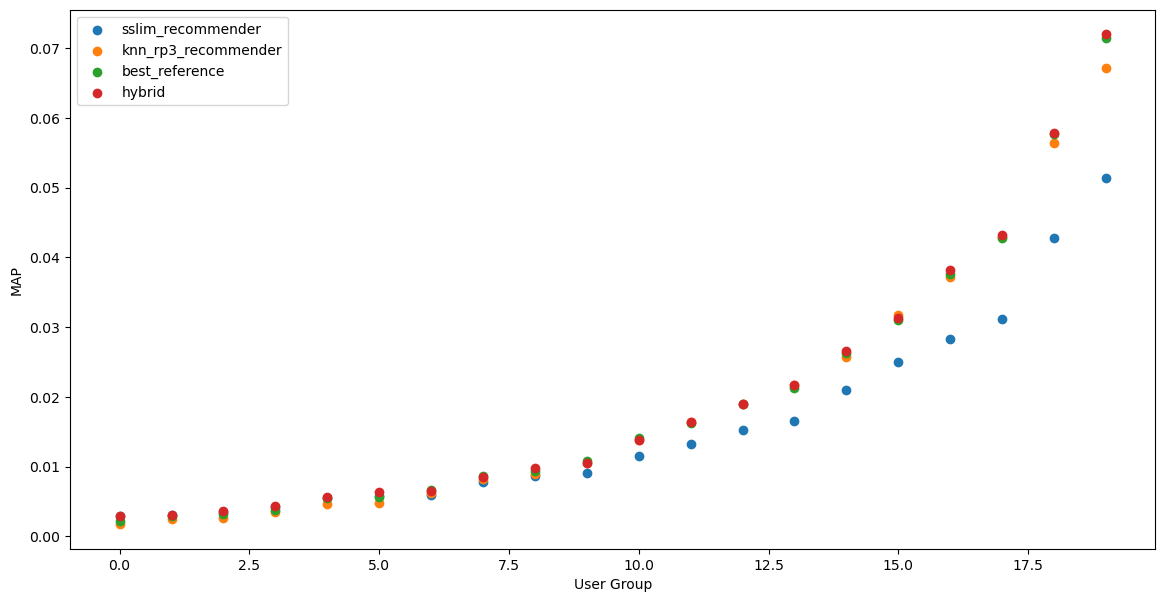

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(14, 7))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label,)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### Evaluation

In [ ]:
evaluator_test = EvaluatorHoldout(URMv_test, [10])
ris, _ = evaluator_test.evaluateRecommender(hybrid)
ris

EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 40033 (100.0%) in 37.48 sec. Users per second: 1068


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.041578,0.07059,0.066041,0.020595,0.034159,0.135919,NaN,0.051029,0.27315,0.165769,...,0.961661,0.262677,0.961661,0.026109,8.756322,0.991906,0.059701,0.651108,4.260861,0.266761


In [ ]:
evaluator_test = EvaluatorHoldout(URMv_test, [10])
ris, _ = evaluator_test.evaluateRecommender(best_reference)
ris

EvaluatorHoldout: Ignoring 1596 ( 3.8%) Users that have less than 1 test interactions


/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:276: RuntimeWarning: overflow encountered in power
  return np.sum(np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)),
/Users/daniele/Desktop/RecSys/RecSysChallenge2023-Team/Evaluation/metrics.py:270: RuntimeWarning: invalid value encountered in double_scalars
  ndcg_ = rank_dcg / ideal_dcg


EvaluatorHoldout: Processed 40033 (100.0%) in 12.69 sec. Users per second: 3155


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.041099,0.069824,0.065316,0.020333,0.033679,0.134733,NaN,0.050452,0.271526,0.163997,...,0.961661,0.261116,0.961661,0.047223,9.460574,0.995186,0.10802,0.703496,3.478553,0.276984
